In [1]:
import os
import sys
import numpy as np
import pandas as pd
import joblib

## Machine learning packages
import sklearn
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from category_encoders import OrdinalEncoder

import warnings 
warnings.filterwarnings("ignore")

In [3]:
print(f"Pandas Version : {pd.__version__} ")
print(f"Numpy Version: {np.__version__}")
print(f"scikit-learn Version: {sklearn.__version__}")
print(f"joblib Version: {joblib.__version__}")
print(f"lightgbm Version: {lgb.__version__}")

Pandas Version : 1.1.5 
Numpy Version: 1.19.4
scikit-learn Version: 0.24.0
joblib Version: 1.0.0
lightgbm Version: 3.1.1


In [4]:
data_file = "./Training_data/Placement_Data_Full_Class.csv"

In [5]:
try:
    data = pd.read_csv(data_file)
    print("Succefully")
except:
    print("data can't be Loaded")

Succefully


In [6]:
data.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [8]:
data.describe()

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,108.000000,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,62.209324,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,1.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,54.500000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,108.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,161.500000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,215.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [13]:
import seaborn as sns

<AxesSubplot:>

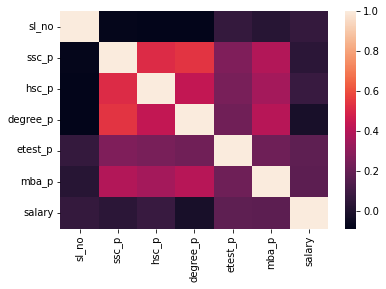

In [15]:
corr = data.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [16]:
exclude_feature = ['sl_no', 'salary', 'status']
# Define Target columns
target = data['status'].map({"Placed": 0 , "Not Placed": 1})

In [18]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = [col for col in numeric_columns if col not in exclude_feature]
categorical_features = [col for col in categorical_columns if col not in exclude_feature]

In [19]:
numeric_columns

['sl_no', 'ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'salary']

In [21]:
categorical_columns

['gender',
 'ssc_b',
 'hsc_b',
 'hsc_s',
 'degree_t',
 'workex',
 'specialisation',
 'status']

In [ ]:
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]
data = data.fillna(0)

# Split data in train and vlaidation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)

In [24]:
X_valid.to_json(path_or_buf='./Training_data/valid.json', orient='records', lines=True)

In [25]:
le = OrdinalEncoder(cols=categorical_features)
le.fit(X_train[categorical_features])
X_train[categorical_features] = le.transform(X_train[categorical_features])
X_valid[categorical_features] = le.transform(X_valid[categorical_features])

In [26]:
 # Perform model training
clf = LGBMClassifier(random_state=10)
clf.fit(X_train, y_train)

# Perform model evaluation 
valid_prediction = clf.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, valid_prediction)
roc_auc = auc(fpr, tpr) # compute area under the curve
print("=====================================")
print("Validation AUC:{}".format(roc_auc))
print("=====================================")

Validation AUC:0.9135338345864662


In [27]:
print(classification_report(y_valid,clf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84        19
           1       0.89      0.57      0.70        14

    accuracy                           0.79        33
   macro avg       0.82      0.76      0.77        33
weighted avg       0.81      0.79      0.78        33



In [29]:
joblib.dump(le, './model/label_encoder.joblib')
joblib.dump(clf, './model/lgb_model.joblib')
joblib.dump(features, './model/features.joblib')
joblib.dump(categorical_features, './model/categorical_features.joblib')

['./model/categorical_features.joblib']